In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import codecs
import re
import os.path
import re
import unicodedata
import string
from time import process_time
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer 

nltk.download('stopwords')
nltk.download('punkt')

import sklearn.naive_bayes as nb
from sklearn import svm
from sklearn import linear_model as lin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, f1_score
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

from wordcloud import WordCloud, ImageColorGenerator 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


mytime = 0
def tic():
    global mytime
    mytime = process_time()
def tac():
    global mytime
    return process_time()-mytime
    
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs
    
def load_pres_test(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage

    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #

        txt = re.sub(r"<[0-9]*:[0-9]*>(.*)","\\1",txt)
        alltxts.append(txt.split(" ",1)[1])
    return alltxts


def equilibrer(x,y):
        '''
            renvoies datax et datay équilibrés
        '''
        x, y = np.array(x), np.array(y)

        chirac = np.where(y==1)[0]
        mitterand = np.where(y==-1)[0]

        nb_delete = np.abs(len(chirac)- len(mitterand))
    
        if len(chirac) > len(mitterand):
            ind = np.random.choice(chirac,nb_delete,replace=False)
        else:
            ind = np.random.choice(chirac,nb_delete,replace=False)


        return np.delete(x,ind),np.delete(y,ind)

def prepare(x,lower=False,numbers=False,punct=False,stemming=True,stopword=True):

    if(numbers == False):
      x = re.sub('[0-9]+', '', x)

    if(punct == False):
      p = string.punctuation 
      p += '\n\r\t'
      x = x.translate(str.maketrans(p, ' ' * len(p))) 

    x = word_tokenize(x)  
    if len(x) == 0:
      return ""

    if(lower == True):
      x = np.char.lower(x)

    if(stopword == False):
      stop_list = stopwords.words('french')
      x = [i for i in x if not i in stop_list]

    if(stemming == True):
      stemmer = SnowballStemmer(language='french')
      x = [stemmer.stem(i) for i in x]

    return " ".join(x)



def my_cross_val(x,y,vectorizer,models_list,model_names,print=False,cv=5):
  f1_score_M = make_scorer(f1_score,average='binary',pos_label=-1)
  f1_score_C = make_scorer(f1_score,average='binary',pos_label=1)
  models=[]
  for m,name in zip(models_list,model_names):
    models.append(Pipeline([('vect', vectorizer), (name, m)]))
    
  scores = {'Chirac Mean': [],
          'Chirac Std': [],
          'Mitterrand Mean': [],
          'Mitterrand Std': []
          }

  for m in models:
      f1_c = cross_val_score(m,x,y,cv=5,scoring=f1_score_C)
      f1_m = cross_val_score(m,x,y,cv=5,scoring=f1_score_M)
      scores['Chirac Mean'] += [f1_c.mean()]
      scores['Chirac Std'] += [f1_c.std()]
      scores['Mitterrand Mean'] += [f1_m.mean()]
      scores['Mitterrand Std'] += [f1_m.std()]


  df = pd.DataFrame(scores, columns = ['Chirac Mean','Chirac Std', 'Mitterrand Mean', 'Mitterrand Std'],index=model_names)
  if print == True:
    return df
  else:
    return scores


def gridSearchSVM(x,y,xt,yt,vect):
  scores_c = []
  scores_m = []
  c_value = [0.1,1,10,100,1000]
  for c in c_value:
    m = svm.LinearSVC(C=c)
    
    scores = get_scores(m,x,y,xt,yt,vect)
    scores_c.append(scores['Chirac']["f1-score"])
    scores_m.append(scores['Mitterrand']["f1-score"])

  c_value = list(map(str,[0.1,1,10,100,1000]))  
  plt.figure()
  plt.title("Grid Search param C de SVM TfidfVectorizer uni+bi+trigrame")
  plt.plot(c_value,scores_c,label="Chirac")
  plt.plot(c_value,scores_m,label="Mitterrand")
  plt.xlabel("valeur de C")
  plt.ylabel("score F1")
  plt.legend()
  plt.show()


def gridSearchLissage(y,ypred):
  
  target_names = ['Mitterrand', 'Chirac']
  scores_c = []
  scores_m = []
  k_value = [2,3,4,5,6,7,8,9,10,11,12]
  for k in k_value:
    new = lissage(ypred,k,2.5)
    
    scores = classification_report(y, new,output_dict=True,target_names=target_names)
    scores_c.append(scores['Chirac']["f1-score"])
    scores_m.append(scores['Mitterrand']["f1-score"])
  k_value = list(map(str,[2,3,4,5,6,7,8,9,10,11,12]))  
  plt.figure()
  plt.title("Grid Search param K de lissage")
  plt.plot(k_value,scores_c,label="Chirac")
  plt.plot(k_value,scores_m,label="Mitterrand")
  plt.xlabel("valeur de K")
  plt.ylabel("score F1")
  plt.legend()
  plt.show()


def get_report(model,datax,datay,vectorizer,p,shuffle=True):
    
    target_names = ['Mitterrand', 'Chirac']
    
    X_train, X_test, y_train, y_test = train_test_split(datax,datay,test_size=p,shuffle=shuffle) 
    X = vectorizer.fit_transform(X_train)
    model.fit(X, y_train)
    X_t = vectorizer.transform(X_test)
    return classification_report(y_test, model.predict(X_t), target_names=target_names,output_dict=True)

def preparation_gridSearch(alltxts,alllabs,model,p):
    res=list()
    params=list() # (lower,punc,stemming,stopword)
    for lower in [True,False] : 
        for punct in [True,False]:
            for stemming in [True,False]:
                for stopword in [True,False]:
                    def process(x):
                      return prepare(x,lower=lower, numbers=False, punct=punct, stemming=stemming, stopword=stopword)

                    vect = TfidfVectorizer(preprocessor = process,lowercase=False)
                    report = get_report(model,alltxts,alllabs,vect,p,shuffle=False)
                    res.append((report['Chirac']['f1-score'],report['Mitterrand']['f1-score']))
                    params.append((lower,punct,stemming,stopword,res[-1][0],res[-1][1]))
    return res, params

def split_by_document(fname,p):
    train_X = []
    train_y = []
    test_X = []
    test_y = []
    ids = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    #get all document id's
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        id = re.sub(r"<([0-9]*):[0-9]*:(.)>.*","\\1",txt)
        ids.append(id)
    ids = np.array(list(set(ids)))
    np.random.shuffle(ids)
    test_ids = ids[:int(len(ids)*p)]

    s=codecs.open(fname, 'r','utf-8')
    while True:           
        txt = s.readline()
        if(len(txt))<5:
            break
        # 
        id = re.sub(r"<([0-9]*):[0-9]*:(.)>.*","\\1",txt)
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if id in test_ids:
          if lab.count('M') >0:
              test_y.append(-1)
          else: 
              test_y.append(1)
          test_X.append(txt)
        else:
          if lab.count('M') >0:
              train_y.append(-1)
          else: 
              train_y.append(1)
          train_X.append(txt)
    return  train_X, train_y, test_X, test_y

def get_scores(m,x,y,xt,yt,vect):
  
  target_names = ['Mitterrand', 'Chirac']
  X = vect.fit_transform(np.array(x))
  X_test = vect.transform(np.array(xt))
  m.fit(X, y)
  return classification_report(yt, m.predict(X_test),output_dict=True,target_names=target_names)

from collections import Counter
def lissage(pred, k, coef):
    window = (k-1)//2

    new = list(pred[:window])
    
    for i in range(window,len(pred)-window):
        tmp = Counter(pred[i-window:i+window+1])
        nbC = tmp[1]
        nbM = tmp[-1]
        if nbC > coef*nbM:
            new.append(1)
        else:
            new.append(-1)
    for j in range(window):
        new.append(pred[-(window-j)])


    return new

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
train_X, train_y, test_X, test_y = split_by_document("corpus.tache1.learn.utf8",0.3)

In [ ]:
def load_labels(fname):
    out = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        if lab.count('M') >0:
            out.append(-1)
        else: 
            out.append(1)
    return out


## **Loading Data :**

In [ ]:
vect = CountVectorizer(preprocessor = prepare,lowercase=False)

In [ ]:
m = svm.LinearSVC()
svm_report = get_scores(m,train_X, train_y, test_X, test_y,vect)

m = nb.MultinomialNB()
nb_report = get_scores(m,train_X, train_y, test_X, test_y,vect)

m = lin.LogisticRegression()
lr_report = get_scores(m,train_X, train_y, test_X, test_y,vect)



In [ ]:
scores = {'Chirac': [svm_report['Chirac']['f1-score'],nb_report['Chirac']['f1-score'],lr_report['Chirac']['f1-score']],
        'Mitterrand': [svm_report['Mitterrand']['f1-score'],nb_report['Mitterrand']['f1-score'],lr_report['Mitterrand']['f1-score']]
        }

df = pd.DataFrame(scores, columns = ['Chirac', 'Mitterrand'],index=['SVM','Naive Bayes','Logistic Regression'])

df

,Chirac,Mitterrand
SVM,0.933606,0.466788
Naive Bayes,0.931033,0.496529
Logistic Regression,0.941538,0.474352


## **Balancing Data :**

In [ ]:
alltxts_new,alllabs_new = equilibrer(alltxts,alllabs)

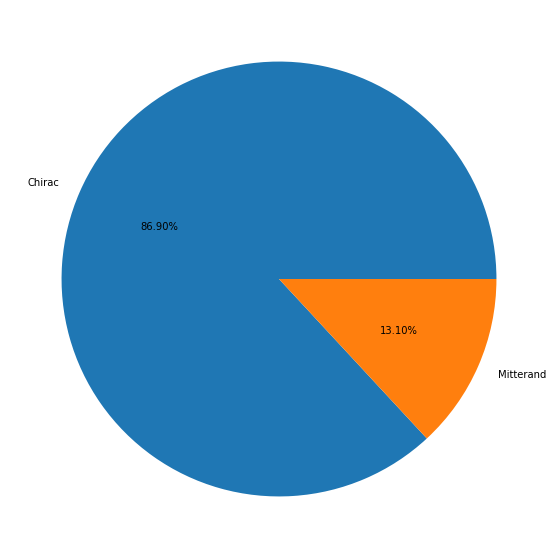

In [ ]:
fig = plt.figure(figsize =(10, 10))
plt.pie([np.where(np.asarray(alllabs) == 1,1,0).sum(),np.where(np.asarray(alllabs) == -1,1,0).sum()], \
        labels = ['Chirac', 'Mitterand'],autopct='%1.2f%%')

plt.show()

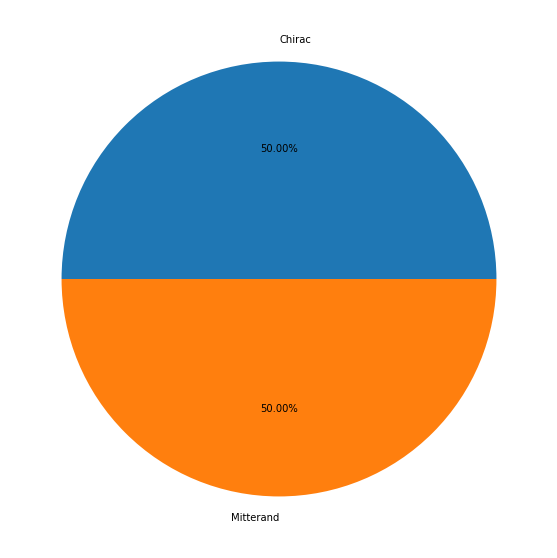

In [ ]:
fig = plt.figure(figsize =(10, 10))
plt.pie([np.where(np.asarray(alllabs_new) == 1,1,0).sum(),np.where(np.asarray(alllabs_new) == -1,1,0).sum()], \
        labels = ['Chirac', 'Mitterand'],autopct='%1.2f%%')

plt.show()

In [ ]:
my_cross_val(alltxts_new,alllabs_new,vect,[svm.LinearSVC(),nb.MultinomialNB(),lin.LogisticRegression()],["SVM","Naive Bayes","Reg Logistique"],print=True)

,Chirac Mean,Chirac Std,Mitterrand Mean,Mitterrand Std
SVM,0.742652,0.011267,0.738125,0.009267
Naive Bayes,0.769704,0.009202,0.776069,0.003987
Reg Logistique,0.768454,0.008353,0.760677,0.006033


## **Grid search for text preparation :**

### SVM:

In [ ]:
model = svm.LinearSVC()
res, params = preparation_gridSearch(alltxts_new,alllabs_new,model,0.3)

In [ ]:
tmp = np.asarray(params)
data = {
    'to_lower' : list(tmp[:,0]),
    'keep_punct' : list(tmp[:,1]),
    'stemming' : list(tmp[:,2]),
    'keep_stopwords' : list(tmp[:,3]),
    'f1_C' : list(tmp[:,4]),
    'f1_M' : list(tmp[:,5])
}
df = pd.DataFrame(data, columns = ['to_lower','keep_punct','stemming','keep_stopwords','f1_C','f1_M'])
df

,to_lower,keep_punct,stemming,keep_stopwords,f1_C,f1_M
0,1.0,1.0,1.0,1.0,0.763770,0.719341
1,1.0,1.0,1.0,0.0,0.751592,0.709445
2,1.0,1.0,0.0,1.0,0.769734,0.727888
3,1.0,1.0,0.0,0.0,0.755674,0.711143
4,1.0,0.0,1.0,1.0,0.764118,0.719379
5,1.0,0.0,1.0,0.0,0.749331,0.708363
6,1.0,0.0,0.0,1.0,0.769734,0.727888
7,1.0,0.0,0.0,0.0,0.750153,0.705144
8,0.0,1.0,1.0,1.0,0.763770,0.719341
9,0.0,1.0,1.0,0.0,0.756923,0.714664


### Naive Bayes

In [ ]:
model = nb.MultinomialNB()
res, params = preparation_gridSearch(alltxts_new,alllabs_new,model,0.3)

In [ ]:
tmp = np.asarray(params)
data = {
    'to_lower' : list(tmp[:,0]),
    'keep_punct' : list(tmp[:,1]),
    'stemming' : list(tmp[:,2]),
    'keep_stopwords' : list(tmp[:,3]),
    'f1_C' : list(tmp[:,4]),
    'f1_M' : list(tmp[:,5])
}
df = pd.DataFrame(data, columns = ['to_lower','keep_punct','stemming','keep_stopwords','f1_C','f1_M'])
df

,to_lower,keep_punct,stemming,keep_stopwords,f1_C,f1_M
0,1.0,1.0,1.0,1.0,0.744124,0.744577
1,1.0,1.0,1.0,0.0,0.744074,0.739267
2,1.0,1.0,0.0,1.0,0.725051,0.736385
3,1.0,1.0,0.0,0.0,0.733819,0.732282
4,1.0,0.0,1.0,1.0,0.742414,0.742300
5,1.0,0.0,1.0,0.0,0.743231,0.735612
6,1.0,0.0,0.0,1.0,0.725051,0.736385
7,1.0,0.0,0.0,0.0,0.734900,0.730279
8,0.0,1.0,1.0,1.0,0.744124,0.744577
9,0.0,1.0,1.0,0.0,0.746924,0.742627


### Regression logistique :

In [ ]:
model = lin.LogisticRegression()
res, params = preparation_gridSearch(alltxts_new,alllabs_new,model,0.3)

In [ ]:
tmp = np.asarray(params)
data = {
    'to_lower' : list(tmp[:,0]),
    'keep_punct' : list(tmp[:,1]),
    'stemming' : list(tmp[:,2]),
    'keep_stopwords' : list(tmp[:,3]),
    'f1_C' : list(tmp[:,4]),
    'f1_M' : list(tmp[:,5])
}
df = pd.DataFrame(data, columns = ['to_lower','keep_punct','stemming','keep_stopwords','f1_C','f1_M'])
df

,to_lower,keep_punct,stemming,keep_stopwords,f1_C,f1_M
0,1.0,1.0,1.0,1.0,0.776284,0.733495
1,1.0,1.0,1.0,0.0,0.762139,0.720039
2,1.0,1.0,0.0,1.0,0.770995,0.730342
3,1.0,1.0,0.0,0.0,0.766374,0.722559
4,1.0,0.0,1.0,1.0,0.780844,0.736585
5,1.0,0.0,1.0,0.0,0.756103,0.713701
6,1.0,0.0,0.0,1.0,0.770995,0.730342
7,1.0,0.0,0.0,0.0,0.760320,0.719404
8,0.0,1.0,1.0,1.0,0.776284,0.733495
9,0.0,1.0,1.0,0.0,0.766571,0.728058


## **Effects of stemmings on vocab size :**



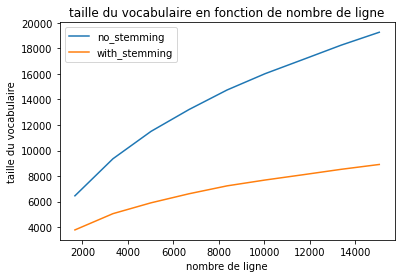

In [ ]:
ind = np.arange(len(alltxts_new))
np.random.shuffle(ind)

dataSize = np.linspace(0,len(alltxts_new),10,dtype=int)[1:]
vocabSize = []
vocabSize_stem = []

def prepare_no_stem(x):
  return prepare(x,lower=False, numbers=False, punct=False, stemming=False, stopword=True)

for x in dataSize:
    vect = CountVectorizer(preprocessor = prepare_no_stem,lowercase=False)
    X = vect.fit_transform(np.array(alltxts_new)[list(ind[:x])])
    vocabSize.append(len(vect.get_feature_names()))

    vect = CountVectorizer(preprocessor = prepare,lowercase=False)
    X = vect.fit_transform(np.array(alltxts_new)[list(ind[:x])])
    vocabSize_stem.append(len(vect.get_feature_names()))

    
plt.figure()
plt.title("taille du vocabulaire en fonction de nombre de ligne")
plt.plot(dataSize,vocabSize,label="no_stemming")
plt.plot(dataSize,vocabSize_stem,label="with_stemming")
plt.xlabel("nombre de ligne")
plt.ylabel("taille du vocabulaire")
plt.legend()
plt.show()

## Document frequency:

In [ ]:
min_df = [0,0.005,0.01,0.05,0.1,0.2]

p=0.3

models = [svm.LinearSVC(),nb.MultinomialNB(),lin.LogisticRegression()]

svm_chirac = []
nb_chirac = []
reglog_chirac = []

svm_mitt = []
nb_mitt = []
reglog_mitt = []

for df in min_df:

  vect = CountVectorizer(preprocessor = process,lowercase=False,min_df=df)


  report = get_report(models[0],alltxts_new,alllabs_new,vect,p,shuffle=False)

  svm_chirac.append(report['Chirac']['f1-score'])
  svm_mitt.append(report['Mitterrand']['f1-score'])


  report = get_report(models[1],alltxts_new,alllabs_new,vect,p,shuffle=False)

  nb_chirac.append(report['Chirac']['f1-score'])
  nb_mitt.append(report['Mitterrand']['f1-score'])


  report = get_report(models[2],alltxts_new,alllabs_new,vect,p,shuffle=False)

  reglog_chirac.append(report['Chirac']['f1-score'])
  reglog_mitt.append(report['Mitterrand']['f1-score'])




    

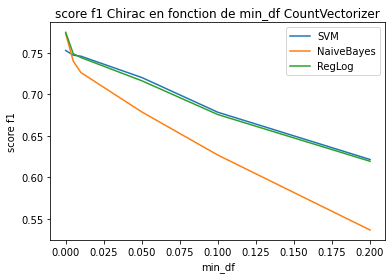

In [ ]:
plt.figure()
plt.title("score f1 Chirac en fonction de min_df CountVectorizer")
plt.plot(min_df,svm_chirac,label="SVM")
plt.plot(min_df,nb_chirac,label="NaiveBayes")
plt.plot(min_df,reglog_chirac,label="RegLog")
plt.xlabel("min_df")
plt.ylabel("score f1")
plt.legend()
plt.show()

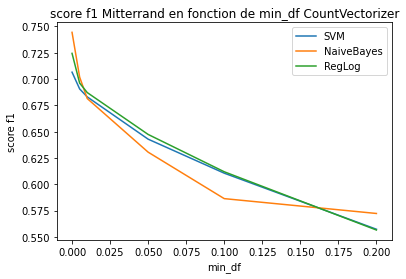

In [ ]:
plt.figure()
plt.title("score f1 Mitterrand en fonction de min_df CountVectorizer")
plt.plot(min_df,svm_mitt,label="SVM")
plt.plot(min_df,nb_mitt,label="NaiveBayes")
plt.plot(min_df,reglog_mitt,label="RegLog")
plt.xlabel("min_df")
plt.ylabel("score f1")
plt.legend()
plt.show()

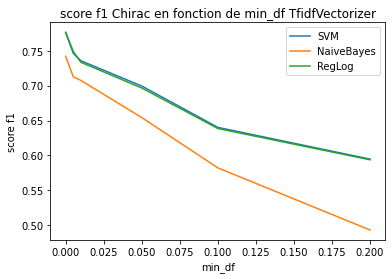

In [ ]:
plt.figure()
plt.title("score f1 Chirac en fonction de min_df TfidfVectorizer")
plt.plot(min_df,svm_chirac,label="SVM")
plt.plot(min_df,nb_chirac,label="NaiveBayes")
plt.plot(min_df,reglog_chirac,label="RegLog")
plt.xlabel("min_df")
plt.ylabel("score f1")
plt.legend()
plt.show()

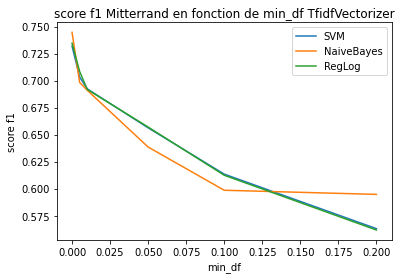

In [ ]:
plt.figure()
plt.title("score f1 Mitterrand en fonction de min_df TfidfVectorizer")
plt.plot(min_df,svm_mitt,label="SVM")
plt.plot(min_df,nb_mitt,label="NaiveBayes")
plt.plot(min_df,reglog_mitt,label="RegLog")
plt.xlabel("min_df")
plt.ylabel("score f1")
plt.legend()
plt.show()

In [ ]:
max_df = [1.0,0.9,0.8,0.5]

p=0.3

models = [svm.LinearSVC(),nb.MultinomialNB(),lin.LogisticRegression()]

svm_chirac = []
nb_chirac = []
reglog_chirac = []

svm_mitt = []
nb_mitt = []
reglog_mitt = []

for df in max_df:

  vect = CountVectorizer(preprocessor = process,lowercase=False,max_df=df)


  report = get_report(models[0],alltxts_new,alllabs_new,vect,p,shuffle=False)

  svm_chirac.append(report['Chirac']['f1-score'])
  svm_mitt.append(report['Mitterrand']['f1-score'])


  report = get_report(models[1],alltxts_new,alllabs_new,vect,p,shuffle=False)

  nb_chirac.append(report['Chirac']['f1-score'])
  nb_mitt.append(report['Mitterrand']['f1-score'])


  report = get_report(models[2],alltxts_new,alllabs_new,vect,p,shuffle=False)

  reglog_chirac.append(report['Chirac']['f1-score'])
  reglog_mitt.append(report['Mitterrand']['f1-score'])




    

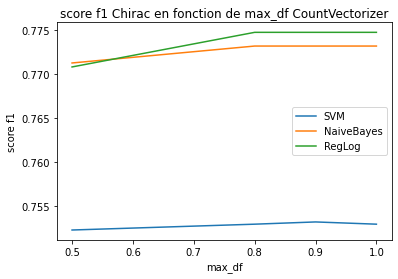

In [ ]:
plt.figure()
plt.title("score f1 Chirac en fonction de max_df CountVectorizer")
plt.plot(max_df,svm_chirac,label="SVM")
plt.plot(max_df,nb_chirac,label="NaiveBayes")
plt.plot(max_df,reglog_chirac,label="RegLog")
plt.xlabel("max_df")
plt.ylabel("score f1")
plt.legend()
plt.show()

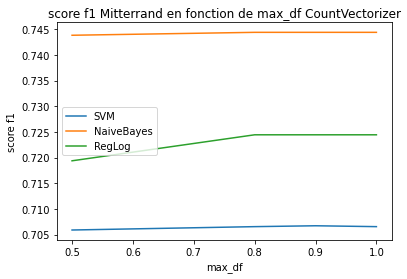

In [ ]:
plt.figure()
plt.title("score f1 Mitterrand en fonction de max_df CountVectorizer")
plt.plot(max_df,svm_mitt,label="SVM")
plt.plot(max_df,nb_mitt,label="NaiveBayes")
plt.plot(max_df,reglog_mitt,label="RegLog")
plt.xlabel("max_df")
plt.ylabel("score f1")
plt.legend()
plt.show()

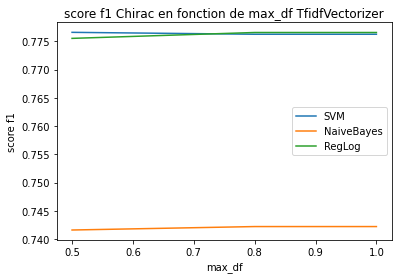

In [ ]:
plt.figure()
plt.title("score f1 Chirac en fonction de max_df TfidfVectorizer")
plt.plot(max_df,svm_chirac,label="SVM")
plt.plot(max_df,nb_chirac,label="NaiveBayes")
plt.plot(max_df,reglog_chirac,label="RegLog")
plt.xlabel("max_df")
plt.ylabel("score f1")
plt.legend()
plt.show()

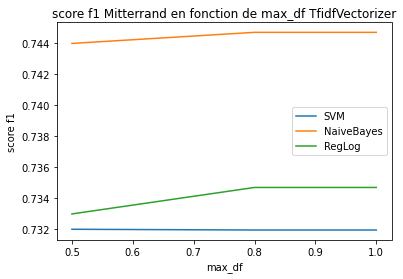

In [ ]:
plt.figure()
plt.title("score f1 Mitterrand en fonction de max_df TfidfVectorizer")
plt.plot(max_df,svm_mitt,label="SVM")
plt.plot(max_df,nb_mitt,label="NaiveBayes")
plt.plot(max_df,reglog_mitt,label="RegLog")
plt.xlabel("max_df")
plt.ylabel("score f1")
plt.legend()
plt.show()

## Uni,Bi,Tri GRAM

In [ ]:
p=0.3

models = [svm.LinearSVC(),nb.MultinomialNB(),lin.LogisticRegression()]

unigram_chirac = []
bigram_chirac = []
trigram_chirac = []
uni_bigram_chirac = []
uni_bi_trigram_chirac = []

unigram_mitt = []
bigram_mitt = []
trigram_mitt = []
uni_bigram_mitt = []
uni_bi_trigram_mitt = []

for m in models:

  vect = TfidfVectorizer(preprocessor = process,lowercase=False)
  report = get_report(m,alltxts_new,alllabs_new,vect,p,shuffle=False)

  unigram_chirac.append(report['Chirac']['f1-score'])
  unigram_mitt.append(report['Mitterrand']['f1-score'])

  vect = TfidfVectorizer(preprocessor = process,lowercase=False,ngram_range=(2,2))
  report = get_report(m,alltxts_new,alllabs_new,vect,p,shuffle=False)

  bigram_chirac.append(report['Chirac']['f1-score'])
  bigram_mitt.append(report['Mitterrand']['f1-score'])

  vect = TfidfVectorizer(preprocessor = process,lowercase=False,ngram_range=(3,3))
  report = get_report(m,alltxts_new,alllabs_new,vect,p,shuffle=False)

  trigram_chirac.append(report['Chirac']['f1-score'])
  trigram_mitt.append(report['Mitterrand']['f1-score'])

  vect = TfidfVectorizer(preprocessor = process,lowercase=False,ngram_range=(1,2))
  report = get_report(m,alltxts_new,alllabs_new,vect,p,shuffle=False)

  uni_bigram_chirac.append(report['Chirac']['f1-score'])
  uni_bigram_mitt.append(report['Mitterrand']['f1-score'])

  vect = TfidfVectorizer(preprocessor = process,lowercase=False,ngram_range=(1,3))
  report = get_report(m,alltxts_new,alllabs_new,vect,p,shuffle=False)

  uni_bi_trigram_chirac.append(report['Chirac']['f1-score'])
  uni_bi_trigram_mitt.append(report['Mitterrand']['f1-score'])



  

In [ ]:
scores_chirac = np.array([unigram_chirac, bigram_chirac, trigram_chirac, uni_bigram_chirac, uni_bi_trigram_chirac])
scores_mitt = np.array([unigram_mitt, bigram_mitt, trigram_mitt, uni_bigram_mitt, uni_bi_trigram_mitt])

In [ ]:
def plot_score_ngram(scores,title):
  colors = ['red','yellow', 'blue','orange','green']
  model_names = [1,2,3]
  labels = ["unigram", "bigram", "trigram", "uni+bigram","uni+bi+trigram"]
  names = ["SVM","NaiveBayes","RegLog"]


  x_positions = np.array([1,2,3])

  number_of_groups = scores.shape[0]
  fill_factor =  .8  # ratio of the groups width
                    # relatively to the available space between ticks
  bar_width = np.diff(x_positions).min()/number_of_groups * fill_factor


  for i, groupdata in enumerate(scores): 
      bar_positions = x_positions - number_of_groups*bar_width/2 + (i + 0.5)*bar_width
      plt.bar(bar_positions, groupdata, bar_width,
              align='center',
              linewidth=1, edgecolor='k',
              color=colors[i], alpha=0.7,
              label=labels[i])

  plt.xticks(x_positions,names);
  plt.legend(loc=(1.04,0)); 
  plt.title(title)
  plt.xlabel('model')
  plt.ylabel('f1 score')

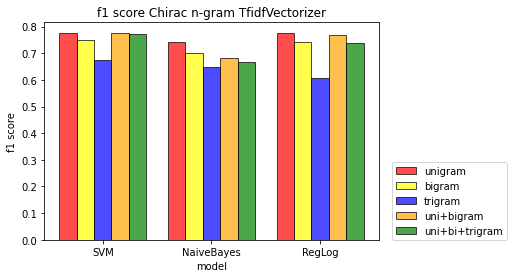

In [ ]:
plot_score_ngram(scores_chirac,"f1 score Chirac n-gram TfidfVectorizer")

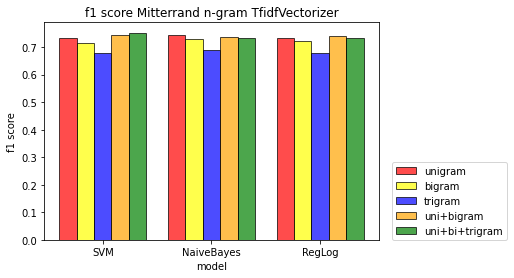

In [ ]:
plot_score_ngram(scores_mitt,"f1 score Mitterrand n-gram TfidfVectorizer")

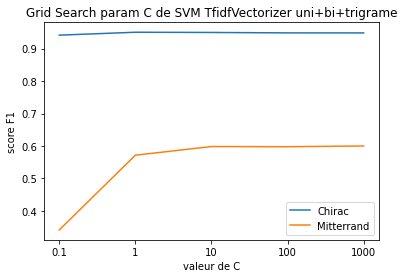

In [ ]:
vect = TfidfVectorizer(lowercase=False,ngram_range=(1,3))
gridSearchSVM(train_X,train_y,test_X,test_y,vect)

In [ ]:
f = codecs.open("best_labels.txt","r","utf-8")
l = f.read().split()
l = np.asarray(l)

l = np.where(l=='C',1,-1)
f.close()
classification_report(alllabs_test, l,output_dict=True)

{'-1': {'f1-score': 0.8344388086877357,
  'precision': 0.8242548818088387,
  'recall': 0.8448775348959705,
  'support': 3797},
 '1': {'f1-score': 0.9727029055430471,
  'precision': 0.9746884400515685,
  'recall': 0.9707254440402311,
  'support': 23365},
 'accuracy': 0.9531330535306678,
 'macro avg': {'f1-score': 0.9035708571153913,
  'precision': 0.8994716609302036,
  'recall': 0.9078014894681008,
  'support': 27162},
 'weighted avg': {'f1-score': 0.9533748451734272,
  'precision': 0.9536591999128583,
  'recall': 0.9531330535306678,
  'support': 27162}}

In [ ]:
def process(x):
  return prepare(x)

vect = CountVectorizer(preprocessor=process,lowercase=False,min_df=5)
X = vect.fit_transform(np.array(train_X))
X_test = vect.transform(np.array(test_X))
mm = nb.MultinomialNB()
mm.fit(X, train_y)
classification_report(test_y, mm.predict(X_test),output_dict=True)


{'-1': {'f1-score': 0.520749947335159,
  'precision': 0.5364583333333334,
  'recall': 0.5059353254195661,
  'support': 2443},
 '1': {'f1-score': 0.9235319821182482,
  'precision': 0.9192372030779525,
  'recall': 0.9278670809131433,
  'support': 14806},
 'accuracy': 0.8681082961331091,
 'macro avg': {'f1-score': 0.7221409647267036,
  'precision': 0.727847768205643,
  'recall': 0.7169012031663546,
  'support': 17249},
 'weighted avg': {'f1-score': 0.8664853990713999,
  'precision': 0.865023696278364,
  'recall': 0.8681082961331091,
  'support': 17249}}

In [ ]:
def process(x):
  return prepare(x)

vect = TfidfVectorizer(lowercase=False,ngram_range=(1,3))
X = vect.fit_transform(np.array(alltxts))
X_test = vect.transform(np.array(alltxts_test))
mm = svm.LinearSVC(C=100)
mm.fit(X, alllabs)
l = mm.predict(X_test)
classification_report(alllabs_test, l,output_dict=True)


{'-1': {'f1-score': 0.6436849053835999,
  'precision': 0.7264900662251655,
  'recall': 0.577824598367132,
  'support': 3797},
 '1': {'f1-score': 0.9488706927400172,
  'precision': 0.9336011929417612,
  'recall': 0.9646479777444896,
  'support': 23365},
 'accuracy': 0.9105735954642515,
 'macro avg': {'f1-score': 0.7962777990618086,
  'precision': 0.8300456295834634,
  'recall': 0.7712362880558108,
  'support': 27162},
 'weighted avg': {'f1-score': 0.9062085016424427,
  'precision': 0.9046489453847731,
  'recall': 0.9105735954642515,
  'support': 27162}}

In [ ]:
from collections import Counter
def lissage(pred, k, coef):
    window = (k-1)//2

    new = list(pred[:window])
    
    for i in range(window,len(pred)-window):
        tmp = Counter(pred[i-window:i+window+1])
        nbC = tmp[1]
        nbM = tmp[-1]
        if nbC > coef*nbM:
            new.append(1)
        else:
            new.append(-1)
    for j in range(window):
        new.append(pred[-(window-j)])


    return new

In [ ]:
ll = lissage(l,9,2.5)

classification_report(alllabs_test, ll,output_dict=True)

{'-1': {'f1-score': 0.8344388086877357,
  'precision': 0.8242548818088387,
  'recall': 0.8448775348959705,
  'support': 3797},
 '1': {'f1-score': 0.9727029055430471,
  'precision': 0.9746884400515685,
  'recall': 0.9707254440402311,
  'support': 23365},
 'accuracy': 0.9531330535306678,
 'macro avg': {'f1-score': 0.9035708571153913,
  'precision': 0.8994716609302036,
  'recall': 0.9078014894681008,
  'support': 27162},
 'weighted avg': {'f1-score': 0.9533748451734272,
  'precision': 0.9536591999128583,
  'recall': 0.9531330535306678,
  'support': 27162}}

In [ ]:
f = codecs.open("best_labels.txt", "w", "utf-8")
for ligne in ll:
  if ligne == -1:
    f.write('M\n')
  if ligne == 1:
    f.write('C\n')
f.close()


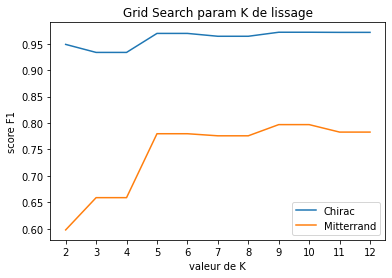

In [ ]:
gridSearchLissage(test_y,l)